<a href="https://colab.research.google.com/github/nitron-alpha-kplr/DEEP-LEARNING-II/blob/main/frozen_desserts_forecasting_LSTM_TF_exercice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

**<h2>Problem Statement: </h2>** 

- To forecast the manufacturing of Ice Cream and Frozen Dessert provided by a previous production history.

</br>

**Data used**: [Click here to download](https://fred.stlouisfed.org/series/IPN31152N) 
</br>

***Keywords:*** *RNN, Timeseries Generator, LSTM*

---

**<h2>Project Planning :</h2>** 


### **1. Data Understanding**
- **Imports -** 
  - Contains all the imports necessary for reading data, visualizations and model buiding and evaluating.
- **Getting Data -** 
  - Reading the csv, and infering the dates from data.
- **Exploring Data -** 
  - Understanding the nature of the data .info() and graphs
  - Obtaining the number of years and months present.


### **2. Data Preparation**
- **Train Test Split -** 
  - Splitting data in to train and test data.
  - Visualizing the train and test data
- **Scaling Data -** 
  - Scaling train and test set using a MinMax Scaler.


### **3. Building Train and Test Generators**
- Creating a Time series generator for train data and test data.
- Understand the working of a created generator (train_gen)


### **4. Model Building**
- Creating a Sequential Long Short-Term Memory (LSTM) *RNN* model.
- Compiling and Fitting the created model with *Early Stopping* and checking the model summary


### **4. Evaluation**
- **Training and Validation Losses -** 
  - Visualising training loss and validation loss.
- **Predictions -** 
  - Predicting the test data and plotting it against true values.
  - Evaluation of model with RMSE and SI.

### **5. Forecasting** 
  - Building a complete model with accepted parameters on whole dataset without splitting.
  - Forecasting the manufacturing for future 12 months and visualizing it.

---


# 1.**Data Understanding**
---

## **Imports**

In [31]:
# Basic Imports
import numpy as np
import pandas as pd
import os

# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
sns.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (15,8)  

# Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import mean_squared_error

## **Getting Data**

In [32]:
df = pd.read_csv('IPN31152N.csv') # Download the dataset from the above provided link
df.head()

,DATE,IPN31152N
0,1972-01-01,60.1529
1,1972-02-01,67.2738
2,1972-03-01,74.4713
3,1972-04-01,78.3607
4,1972-05-01,85.0335


In [33]:
df['DATE'].dtype

dtype('O')

In [34]:
# Making Date column as index and dates as Datetime objects
df = pd.read_csv('IPN31152N.csv', index_col='DATE', parse_dates=True)
df


,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335
...,...
2022-11-01,94.9638
2022-12-01,91.1341
2023-01-01,93.7389


## **Exploring Data**
---

In [14]:
df.index

RangeIndex(start=0, stop=615, step=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       615 non-null    object 
 1   IPN31152N  615 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.7+ KB


<Axes: >

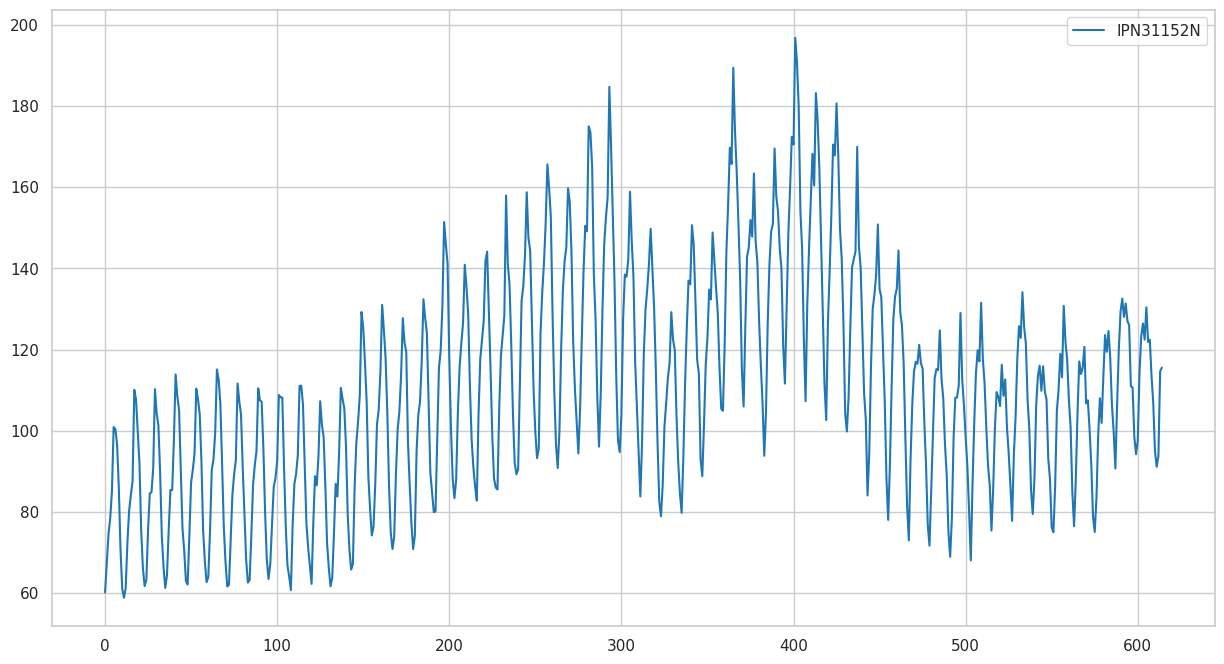

In [16]:
df.plot()

In [17]:
print(f'Number of months present - {len(df)}')
print(f'Number of years present - {len(df)/12}') # as each month has one observation

Number of months present - 615
Number of years present - 51.25


In [18]:
df.tail().index 

RangeIndex(start=610, stop=615, step=1)

# 2.**Data Preparation**
---

## **Train Test Split**

In [35]:
test_len = 18 # Considering last 18 months as test set.

ind = len(df) - test_len
train = df[:ind] # 1972-01 to 2019-10
test = df[ind:] # 2019-11 to 2021-04

print(f'Length of train set: {len(train)}')
print(f'Length of test set: {len(test)}')

Length of train set: 597
Length of test set: 18


In [37]:
# Train data
train

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335
...,...
2021-05-01,128.0570
2021-06-01,131.3761
2021-07-01,127.0658


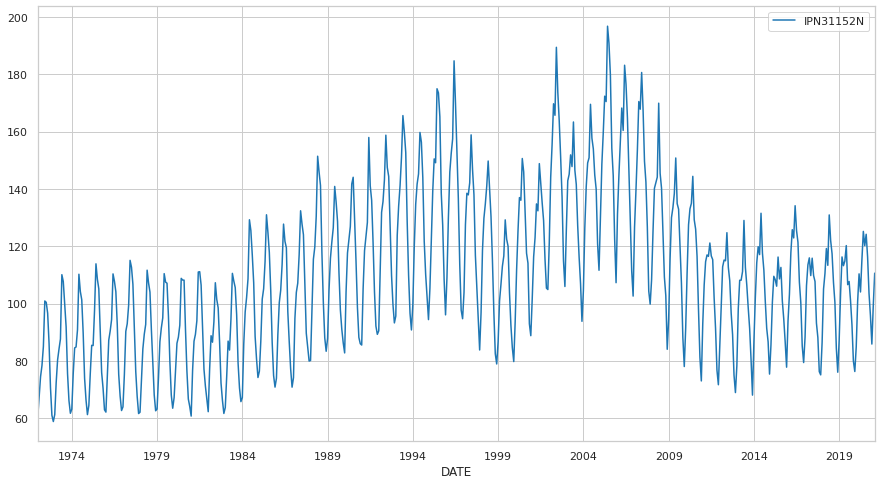

In [ ]:
# Train Data plot
train.plot()

In [ ]:
# Test Data
test

,IPN31152N
DATE,
2021-03-01,117.5007
2021-04-01,118.9769
2021-05-01,113.6948
2021-06-01,115.5991
2021-07-01,111.0626
2021-08-01,109.6379
2021-09-01,96.3444
2021-10-01,96.0669
2021-11-01,85.6469


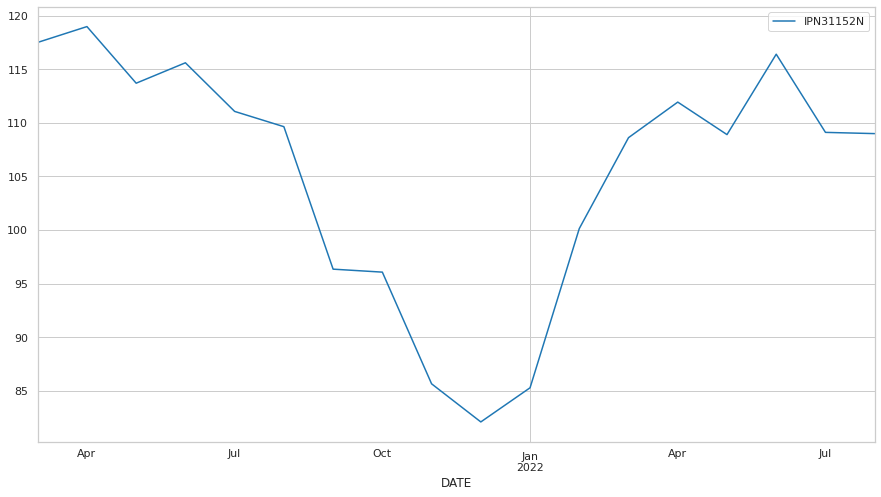

In [ ]:
# Test Data Plot
test.plot()

## **Scaling Data**

In [38]:
# Scaling Test and Train Data
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

## **Building Train and Test Generators**

In [40]:
inp_len = 12 # Generator takes 12 points as X_train and
out_len = 1 # takes next point as y_train
n_feat = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = inp_len,
                                batch_size = out_len)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                                targets = test_sc,
                                length = inp_len,
                                batch_size = out_len)
     

In [41]:
print(f'Length of Train set: {len(train)}')
print(f'Length of Train Generator:{len(train_gen)}') # Note: Generator will exclude last "inp_len (12)" points.
print(f'Length of Test set: {len(test)}')
print(f'Length of Test Generator:{len(test_gen)}')

Length of Train set: 597
Length of Train Generator:585
Length of Test set: 18
Length of Test Generator:6


> Understanding a Generator (train_gen)

In [42]:
X, y = train_gen[0] # First gen object
print(f'First train_gen object input (X): {len(X[0])}\n {X}\n') # 'inp_len' data points
print(f'First train_gen object output (y): {len(y[0])}\n {y}') # 'out_len' data points

First train_gen object input (X): 12
 [[[0.00946844]
  [0.06107885]
  [0.11324444]
  [0.14143379]
  [0.18979649]
  [0.30491157]
  [0.30149644]
  [0.27411739]
  [0.19733776]
  [0.08531384]
  [0.0156138 ]
  [0.        ]]]

First train_gen object output (y): 1
 [[0.01773956]]


In [43]:
# Actual scaled train set
train_sc[:inp_len+out_len]

array([[0.00946844],
       [0.06107885],
       [0.11324444],
       [0.14143379],
       [0.18979649],
       [0.30491157],
       [0.30149644],
       [0.27411739],
       [0.19733776],
       [0.08531384],
       [0.0156138 ],
       [0.        ],
       [0.01773956]])

# 3.**Model Building**
---

In [44]:
# Creating Model
model = Sequential()

# Input layer
model.add(LSTM(150, activation='relu', input_shape=(inp_len, n_feat))) #LSTM RNN
model.add(Dropout(0.15))
# Output layer
model.add(Dense(1))

In [46]:
# Compile the created model
model.compile(optimizer='adam',
              loss='mse')

# Monitor the "validation_loss" and 
# when "min" value is reached during training, wait for "2" epochs and stop training.
early_stop = EarlyStopping(monitor='val_loss',
                           verbose=1,
                           mode='min',
                           patience=2)

# Fit the model to the generators created.
model.fit_generator(train_gen,
                    validation_data = test_gen,
                    epochs = 10,
                    callbacks = [early_stop])

Epoch 1/10


<ipython-input-46-a44d8a5c86b6>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen,


585/585 [==============================] - 7s 9ms/step - loss: 0.0211 - val_loss: 0.0064
Epoch 2/10
585/585 [==============================] - 5s 9ms/step - loss: 0.0097 - val_loss: 0.0026
Epoch 3/10
585/585 [==============================] - 5s 9ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 4/10
585/585 [==============================] - 6s 11ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 5/10
585/585 [==============================] - 6s 10ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 6/10
585/585 [==============================] - 5s 9ms/step - loss: 0.0056 - val_loss: 7.0900e-04
Epoch 7/10
585/585 [==============================] - 5s 9ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 8/10
585/585 [==============================] - 5s 9ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 8: early stopping


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


#4.**Evaluation**
---


## **Training and Validation Losses**

In [48]:
# New dataframe "losses" with model.history.history data
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.021089,0.006374
1,0.009680,0.002632
2,0.007637,0.005854
3,0.006248,0.001778
4,0.006068,0.007916
5,0.005598,0.000709
6,0.005253,0.001686
7,0.004510,0.001566


<Axes: >

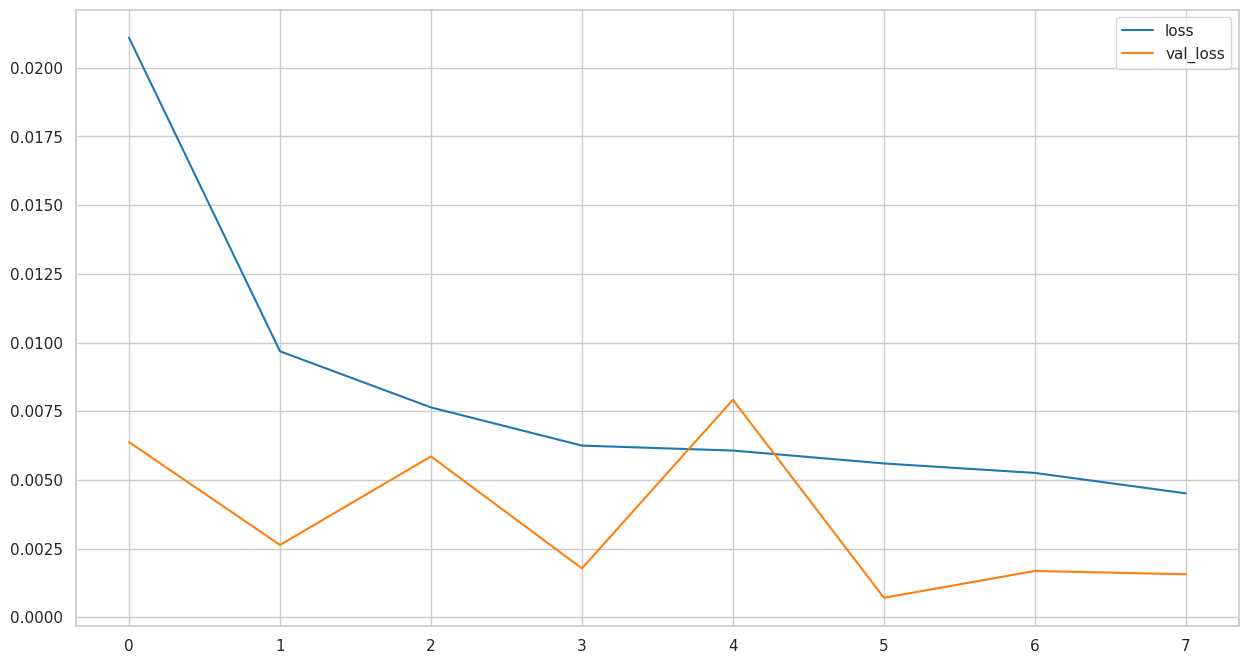

In [49]:
# Plot training loss v/s validation loss
losses[['loss','val_loss']].plot()

## **Predictions**

Idea here for the predictions is,
first, we predict the last batch that was not included in train_gen, 
then first row is discarded and predicted values are added at last as illustrated below, and this repeats till the length of testset.
>

> ```
1. [x1 x2 x3 x4 x5] -> M -> [y1] 
2. [x2 x3 x4 x5 y1] -> M -> [y2]
3. [x3 x4 x5 y1 y2] -> M -> [y3] 
          .
          .
          .     
n. [y1 y2 y3 y4 y5] -> M -> [y6] # Predicting on Predictions
```




In [51]:
y_pred = [] 

train_sc_lastrows = train_sc[-inp_len:] # Last row of scaled train (excluded by train_gen)
batch = train_sc_lastrows.reshape((1, inp_len, n_feat)) # Reshape (1, 12, 1)

for _ in range(len(test)):
  pred = model.predict(batch) # Predict 
  y_pred.append(pred[0]) # Append the 'prediction' to empty list
  batch = np.append(batch[:,1:,:],[pred],axis=1) # Remove first element in 'batch', add prediction at end, and Repeat

1/1 [==============================] - 0s 21ms/step


In [52]:
y_pred = sc.inverse_transform(y_pred) # Remove scaling
test['y_pred'] = y_pred # Adding the predictions to test data for comparision

test

<ipython-input-52-f997945973da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred # Adding the predictions to test data for comparision


,IPN31152N,y_pred
DATE,,
2021-10-01,110.6657,106.133720
2021-11-01,98.5450,98.834460
2021-12-01,94.2224,100.743255
2022-01-01,97.5434,109.949546
2022-02-01,114.0908,118.097640
2022-03-01,123.2298,123.954724
2022-04-01,126.4274,126.928707
2022-05-01,122.4791,128.263380
2022-06-01,130.4224,127.879752


<Axes: xlabel='DATE'>

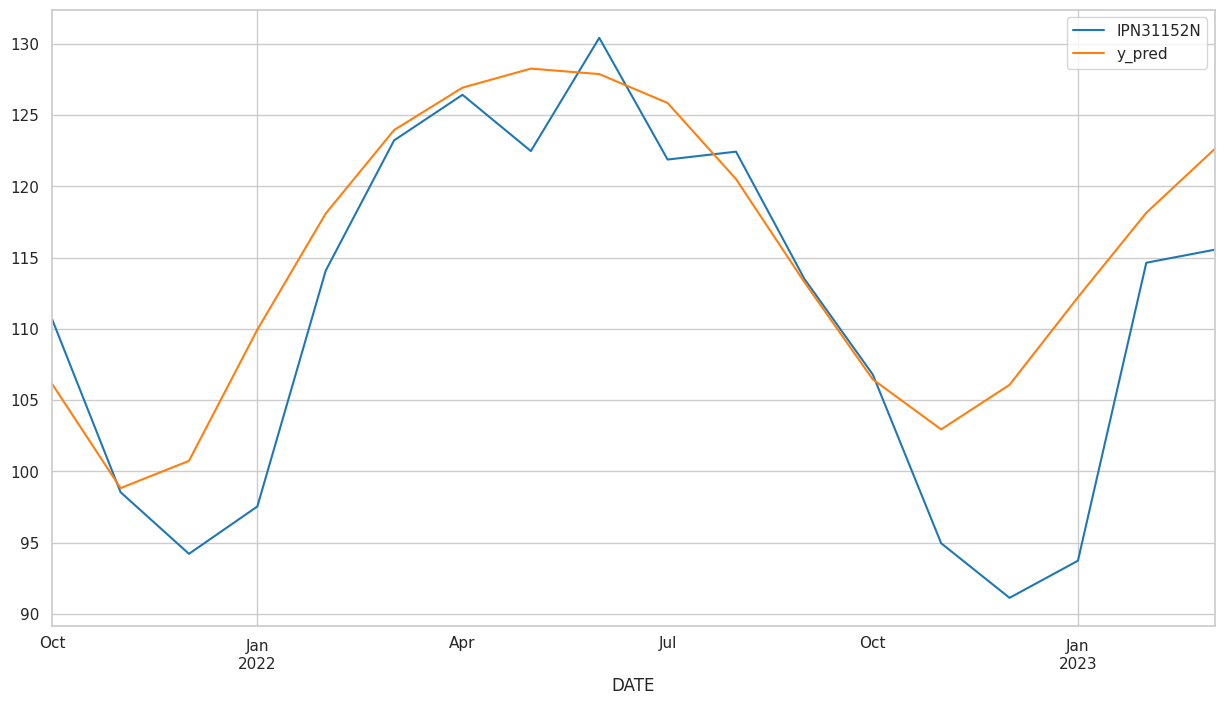

In [53]:
test.plot() # Original Test Data vs Predictions

# Note: LSTM produce different results on each execution

In [55]:
rmse = mean_squared_error(test['IPN31152N'],test['y_pred'])**0.5
df_mean = df['IPN31152N'].mean()
print(f'RMSE : {rmse}')
print(f'Mean : {df_mean}')
print(f'Scatter Index: {rmse/df_mean}') # Less SI -> Better Model

RMSE : 7.395676350799117
Mean : 110.23035560975612
Scatter Index: 0.06709291927698861


# 5.**Forecasting**
---

Accepting the preceding model's performance, Creating a new model with same parameters and fitting on all the available data for forecasting next 12 months.

In [56]:

scaler = MinMaxScaler() 
sc_df = scaler.fit_transform(df) # Scaling complete data

# Generator
gen = TimeseriesGenerator(sc_df,  
                          sc_df,
                          length=inp_len,
                          batch_size = out_len)

# Model
forecaster = Sequential()
forecaster.add(LSTM(150, activation='relu', input_shape=(inp_len, n_feat)))
forecaster.add(Dropout(0.15))
forecaster.add(Dense(1))

# Compile the created model
forecaster.compile(optimizer='adam', loss='mse')

# Fit the model
forecaster.fit_generator(gen, epochs = 5)


interval = 12 # Forecasting Period
forecast = []
sc_df_lastrows = sc_df[-inp_len:]
batch1 = sc_df_lastrows.reshape((1, inp_len, n_feat))
for _ in range(interval):
  pred1 = forecaster.predict(batch1)
  forecast.append(pred1[0]) 
  batch1 = np.append(batch1[:,1:,:],[pred1],axis=1)

forecast = scaler.inverse_transform(forecast)

# Creating new DataFrame with Index of future dates
fc_index = pd.date_range(start='2022-08-01', periods=interval, freq='MS')
fc_df = pd.DataFrame(forecast, index=fc_index, columns=['Forecast'])
fc_df # Forecast Dataframe

Epoch 1/5


<ipython-input-56-f0cabed793b5>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  forecaster.fit_generator(gen, epochs = 5)


603/603 [==============================] - 8s 9ms/step - loss: 0.0234
Epoch 2/5
603/603 [==============================] - 5s 9ms/step - loss: 0.0127
Epoch 3/5
603/603 [==============================] - 5s 9ms/step - loss: 0.0080
Epoch 4/5
603/603 [==============================] - 5s 9ms/step - loss: 0.0059
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


,Forecast
2022-08-01,126.900294
2022-09-01,132.413373
2022-10-01,135.147045
2022-11-01,133.982920
2022-12-01,130.171637
2023-01-01,122.082706
2023-02-01,111.458138
2023-03-01,100.510869
2023-04-01,95.971434
2023-05-01,103.578604


<Axes: xlabel='DATE'>

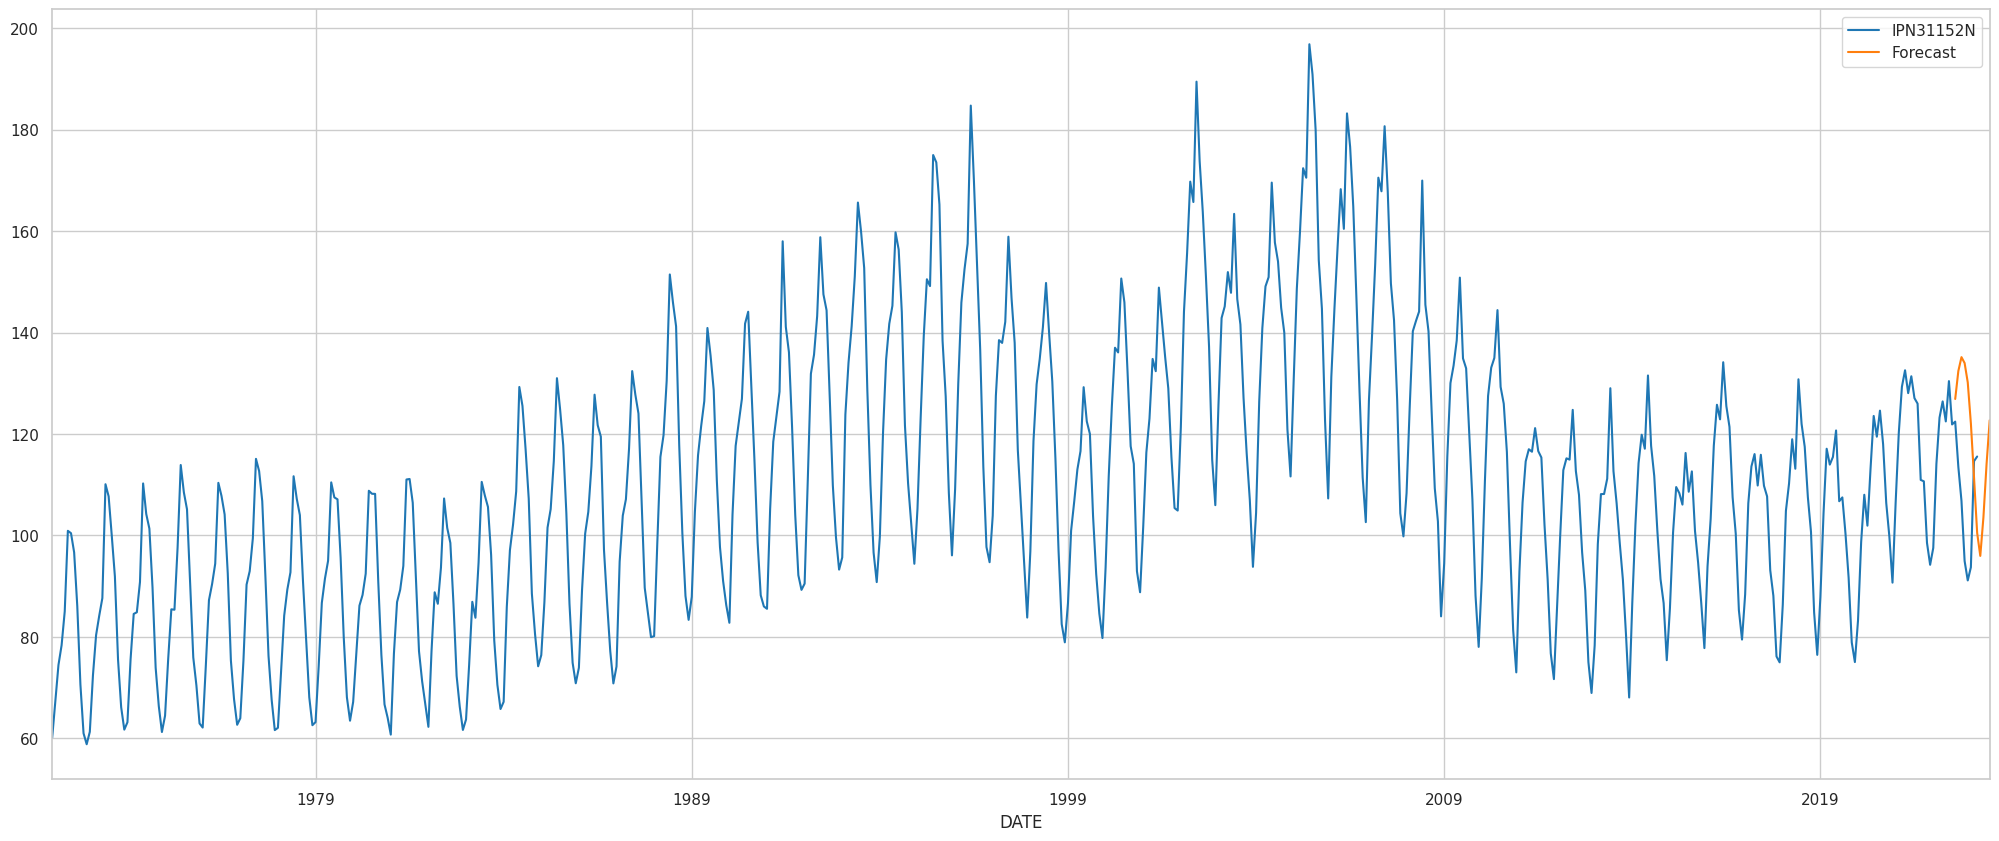

In [57]:
# Complete Graph with Forecasting
ax = df.plot()
fc_df.plot(ax=ax, figsize=(25,10))

(588.0, 642.0)

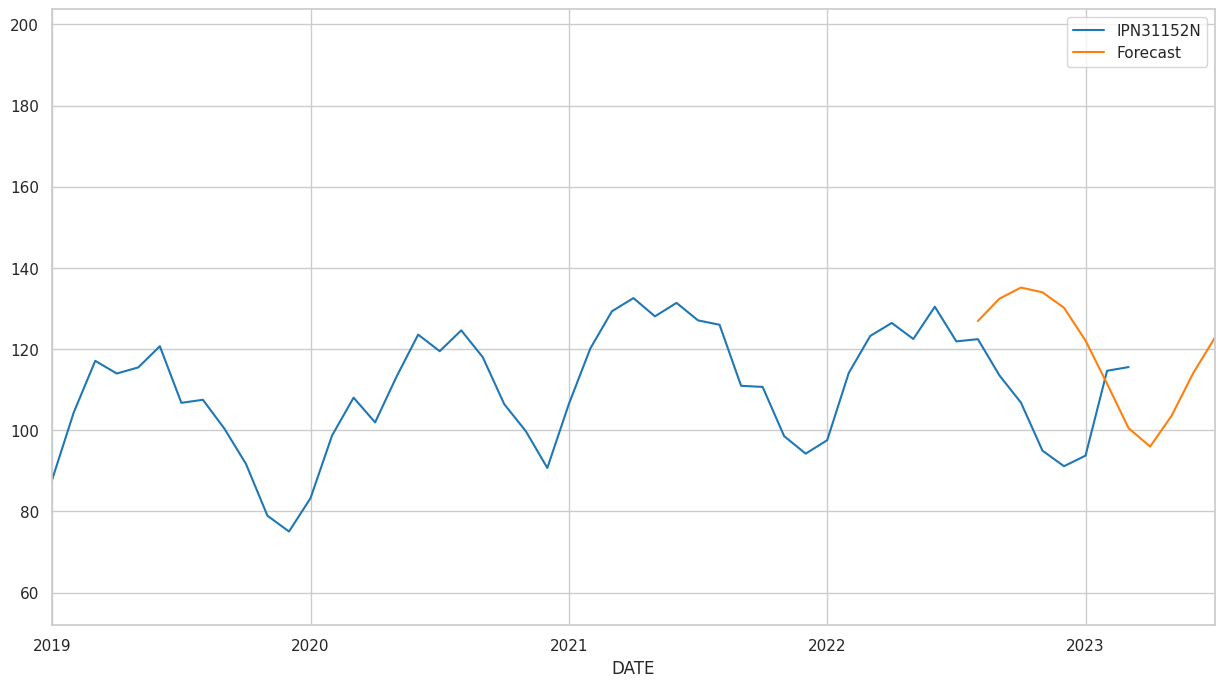

In [58]:
# Forecasting Graph (cropped)
ax = df.plot()
fc_df.plot(ax=ax)
plt.xlim('2019-01-01', fc_index[-1])